# Código TP3: Clustering

In [67]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
from sklearn.preprocessing import scale

# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

## Carga de Datasets "Crabs"

In [68]:
crabs = pd.read_csv("Crabs.csv", sep=',')
crabs = crabs.drop(columns=["rownames", "index"])
print(crabs)

crabs_numpy = crabs.to_numpy()
print(crabs_numpy)

    sp sex    FL    RW    CL    CW    BD
0    B   M   8.1   6.7  16.1  19.0   7.0
1    B   M   8.8   7.7  18.1  20.8   7.4
2    B   M   9.2   7.8  19.0  22.4   7.7
3    B   M   9.6   7.9  20.1  23.1   8.2
4    B   M   9.8   8.0  20.3  23.0   8.2
..  ..  ..   ...   ...   ...   ...   ...
195  O   F  21.4  18.0  41.2  46.2  18.7
196  O   F  21.7  17.1  41.7  47.2  19.6
197  O   F  21.9  17.2  42.6  47.4  19.5
198  O   F  22.5  17.2  43.0  48.7  19.8
199  O   F  23.1  20.2  46.2  52.5  21.1

[200 rows x 7 columns]
[['B' 'M' 8.1 ... 16.1 19.0 7.0]
 ['B' 'M' 8.8 ... 18.1 20.8 7.4]
 ['B' 'M' 9.2 ... 19.0 22.4 7.7]
 ...
 ['O' 'F' 21.9 ... 42.6 47.4 19.5]
 ['O' 'F' 22.5 ... 43.0 48.7 19.8]
 ['O' 'F' 23.1 ... 46.2 52.5 21.1]]


## Carga de Datasets "Lampone"

In [69]:
lampone = pd.read_csv("Lampone.csv", sep=',')
print(lampone)

lampone_numpy = lampone.to_numpy()
print(lampone_numpy)

    anno     m33   m34   m35   m36  m40   m41   m42    m43   m44  ...  m183  \
0   2006   32.24  0.27  0.06  0.01  0.0  0.30  0.02   2.05  0.11  ...  0.00   
1   2006   33.41  0.34  0.05  0.01  0.0  0.12  0.02  10.42  0.25  ...  0.00   
2   2006   31.93  0.32  0.05  0.01  0.0  0.09  0.02   9.32  0.24  ...  0.00   
3   2006   43.62  0.45  0.08  0.02  0.0  0.11  0.02  12.67  0.31  ...  0.00   
4   2006   47.08  0.47  0.09  0.02  0.0  0.20  0.03   3.19  0.12  ...  0.00   
5   2006   21.38  0.20  0.03  0.00  0.0  0.06  0.01  12.01  0.27  ...  0.00   
6   2006   37.20  0.38  0.06  0.01  0.0  0.07  0.02   3.45  0.14  ...  0.00   
7   2006   57.00  0.51  0.08  0.00  0.0  0.08  0.02   2.63  0.09  ...  0.00   
8   2006   13.31  0.16  0.02  0.00  0.0  0.14  0.02  11.92  0.26  ...  0.00   
9   2006  122.75  1.05  0.17  0.01  0.0  0.11  0.02   8.67  0.24  ...  0.00   
10  2006   37.70  0.37  0.05  0.00  0.0  0.09  0.02  19.00  0.39  ...  0.00   
11  2006   39.47  0.38  0.06  0.01  0.0  0.15  0.02 

## Métodos de Comparación de Resultados

In [70]:
# Comentario: para comparar dos soluciones de clustering o una de ellas
#  contra las clases originales se suele usar una tabla, como por ejemplo:

def comparar_tabla(clusters1, clusters2):

    # Suponemos a los clusters numerados desde 0
    nclusters1 = np.max(clusters1) + 1
    nclusters2 = np.max(clusters2) + 1

    conf_matrix = np.zeros((nclusters1, nclusters2), dtype=int)

    for i in range(len(clusters1)):
        conf_matrix[clusters1[i], clusters2[i]] += 1

    print(conf_matrix)
    return conf_matrix


# pero se puede optimizar el match entre los dos clusterings, para hacer
# mejor la tabla, usando:

def comparar_tabla_optim(clusters1, clusters2, print_matrix=False):

    # Suponemos a los clusters numerados desde 0
    nclusters1 = np.max(clusters1) + 1
    nclusters2 = np.max(clusters2) + 1

    conf_matrix = np.zeros((nclusters1, nclusters2), dtype=int)

    for i in range(len(clusters1)):
        conf_matrix[clusters1[i], clusters2[i]] += 1

    # minimum weight matching, optimize the matching between a cluster
    # in clusters1 with one or more clusters in clusters2
    _, col_ind = linear_sum_assignment(-conf_matrix)
    optimized_conf_matrix = conf_matrix[:, col_ind]

    if print_matrix:
        print(optimized_conf_matrix)
    return optimized_conf_matrix

def precision_conf_matrix(conf_matrix):
    correct = np.trace(conf_matrix)
    total = np.sum(conf_matrix)
    accuracy = correct / total
    return accuracy



## Score de Estabilidad de Soluciones de Clustering

In [71]:
# Código de ejemplo de como calcular el score de estabilidad de dos soluciones
# de clustering usando Iris

data = load_iris()
X = data.data
n = X.shape[0]

# Fijar el número de clusters
k = 3

# Crear dos muestras aleatorias del 90% de los datos
ind1 = np.random.choice(n, int(0.9 * n), replace=False)
ind2 = np.random.choice(n, int(0.9 * n), replace=False)

# Aplicar K-Means a ambas muestras
cc1 = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind1]).labels_
cc2 = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind2]).labels_

# Reinsertar los clusters en un vector de longitud n, con 0 en los puntos
# no seleccionados
v1 = np.zeros(n, dtype=int)
v2 = np.zeros(n, dtype=int)

# Se suman 5 a las etiquetas para permitir el truco de la raíz cuadrada
v1[ind1] = cc1 + 5
v2[ind2] = cc2 + 5

# Crear la matriz de similitud: 1 si están en el mismo cluster,
# -1 si están en distinto, 0 si alguno falta
def compute_similarity_matrix(v):
    n = v.shape[0]
    is_valid = v > 0
    valid_mask = np.logical_and.outer(is_valid, is_valid)
    eq_mask = np.equal.outer(v, v)
    m = np.zeros((n,n), dtype=int)
    m[valid_mask & eq_mask] = 1
    m[valid_mask & ~eq_mask] = -1
    return m

m1 = compute_similarity_matrix(v1)
m2 = compute_similarity_matrix(v2)

# Calcular el score de estabilidad
validos = np.sum((v1 * v2) > 0)
if validos > 1:
    score = np.sum((m1 * m2)[np.triu_indices(n, k=1)] > 0) / (validos * (validos - 1) / 2)
else:
    score = 0  # Evita división por cero

print(score)

1.0


# Ejercicio 1

### Crabs con Kmeans

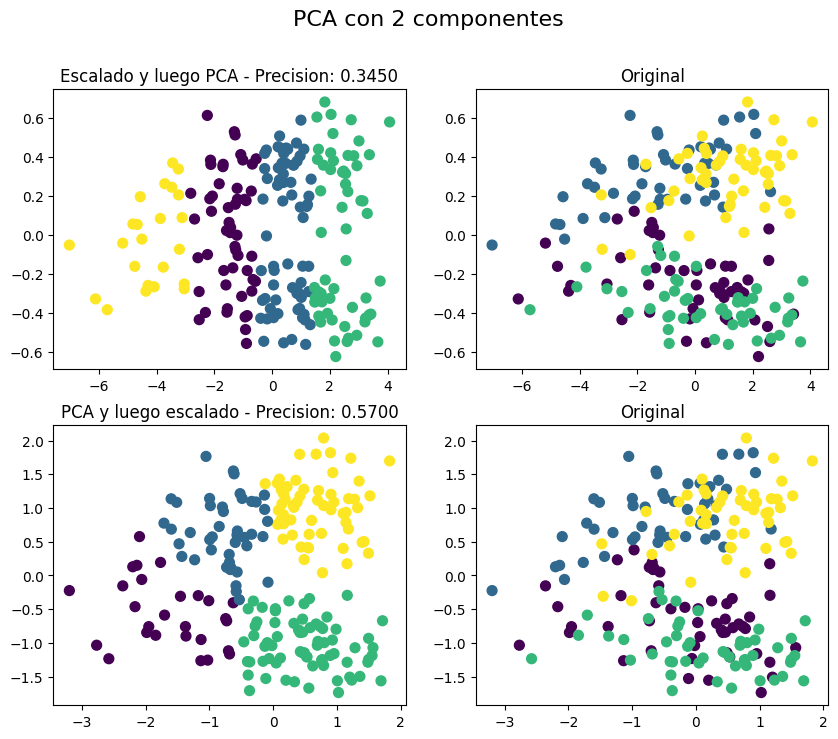

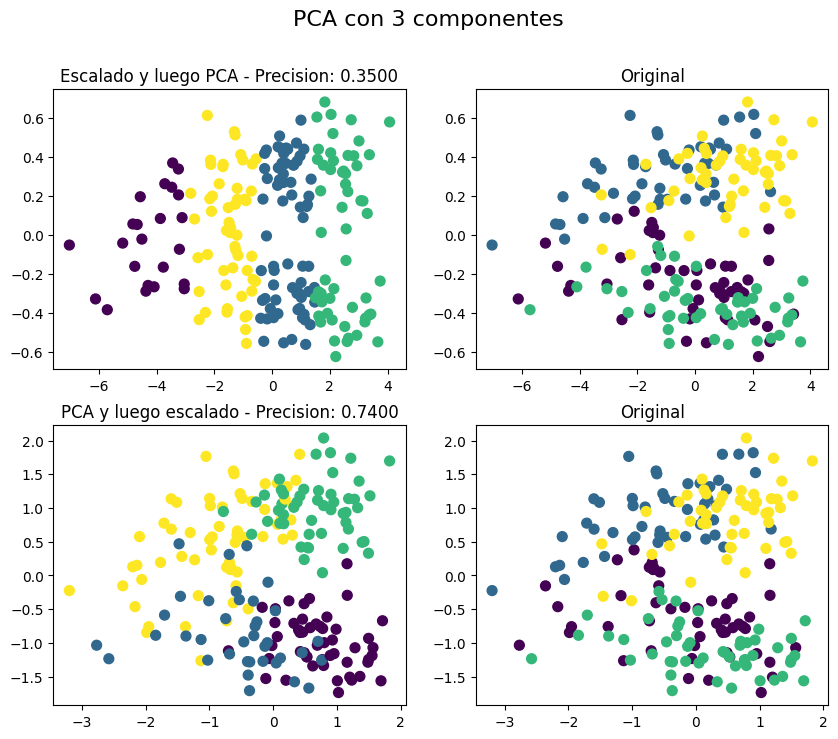

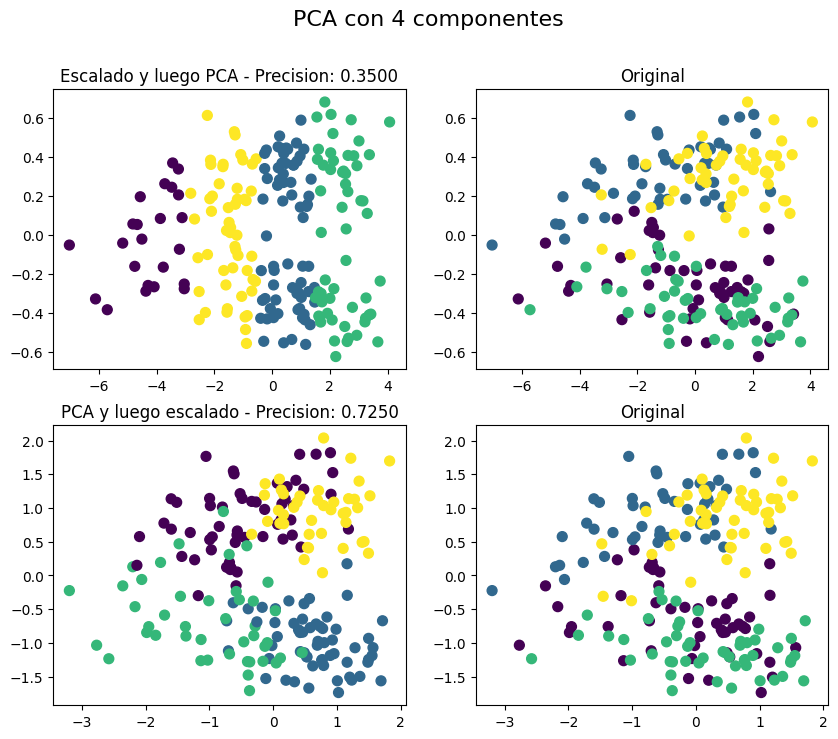

In [88]:
X = crabs.drop(columns=["sp", "sex"])
y = crabs[["sp", "sex"]]
original = pd.factorize(pd.Series(zip(y["sp"], y["sex"])))[0]

# Aplicar logaritmo y escalar
X_log = np.log(X)
X_scaled = scale(X_log, axis=0)

# Probar PCA con 2 y 3 componentes
components_list = [2,3,4]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_log)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    # 4 clusters ya que hay dos especies y dos sexos
    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_scaled_pca)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[0][0].set_title("Escalado y luego PCA - " + f"Precision: {precision:.4f}")
    axes[0][0].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][1].set_title("Original")
    axes[0][1].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_pca_scaled)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[1][0].set_title("PCA y luego escalado - " + f"Precision: {precision:.4f}")
    axes[1][0].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][1].set_title("Original")
    axes[1][1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

Vemos que funciona mucho mejor hacer pca y luego escalar, esto es porque al hacer PCA estamos haciendo que las variables que mas separan los datos tengan mas importancia y si luego escalamos, se escala conservando las importancias de cada variable en los ejes. Esto es muy bueno para hacer los clusters ya que los datos ya estan mejor separados. 

Tambien vemos que hacer la PCA con 3 componentes da muchos mejores resultados que con 2. Pero con 4 ya empeora, esto es porque con mas dimensiones se vacia el espacio de puntos. Se debe conciderar la varianza ganada con cada dimension contra la densidad de datos resultante.

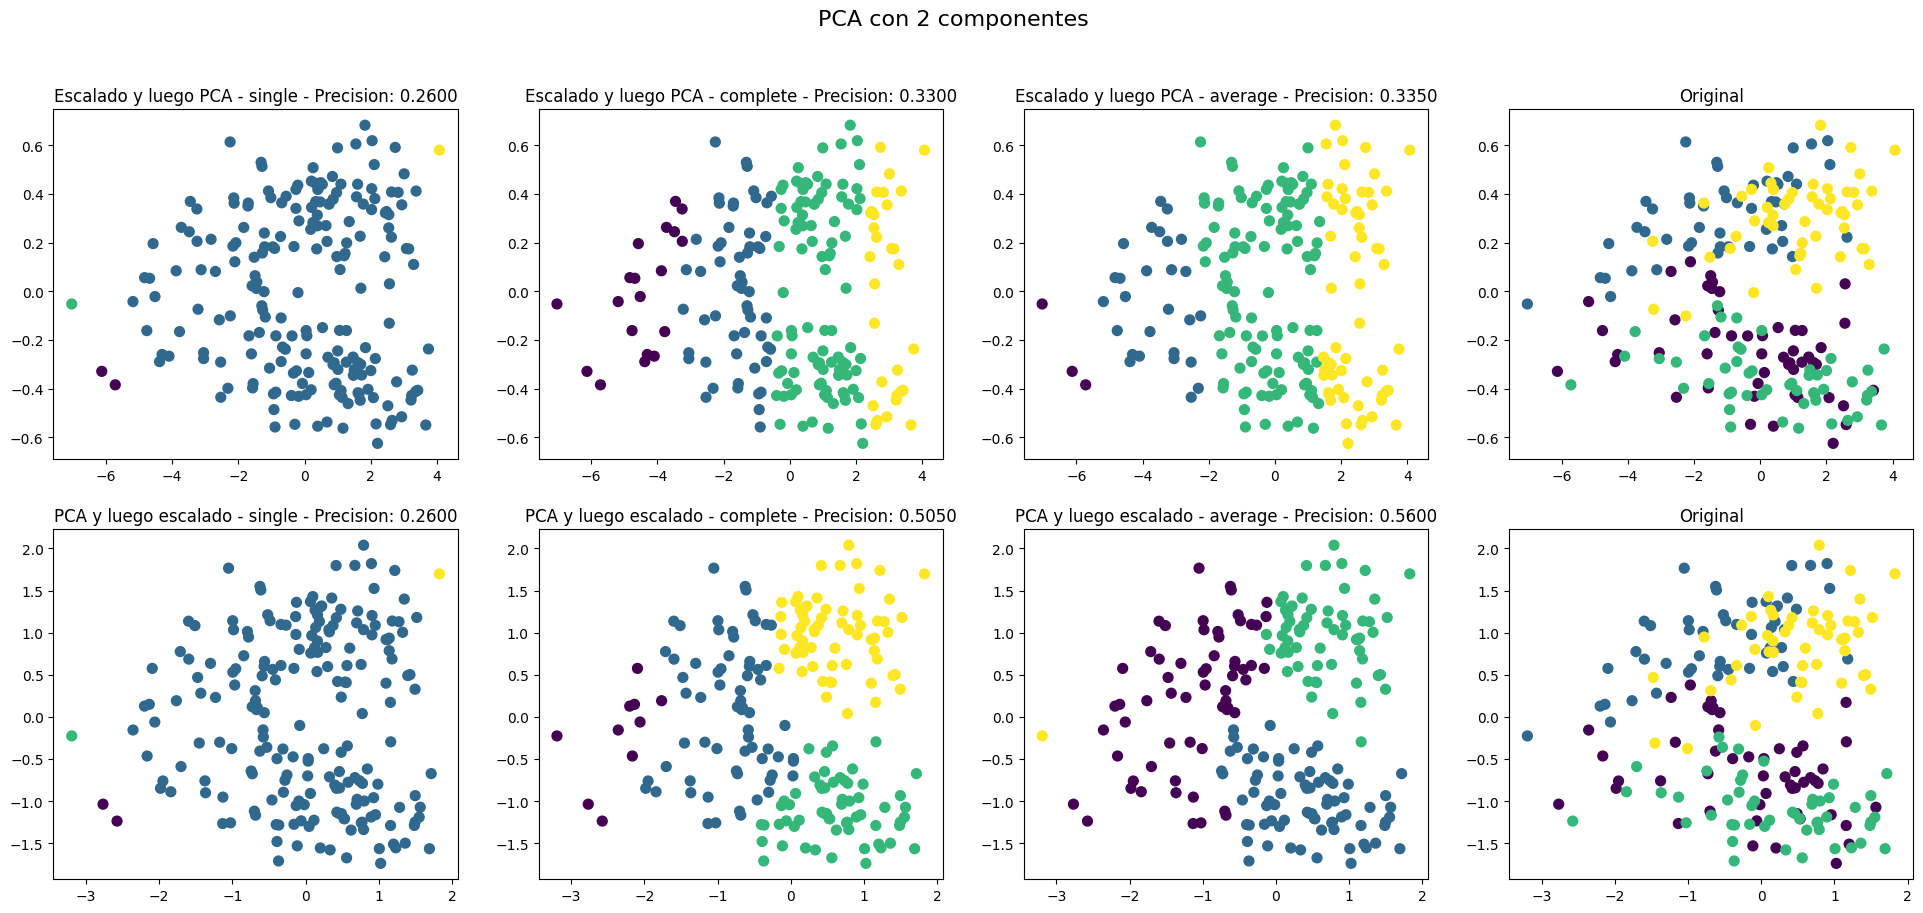

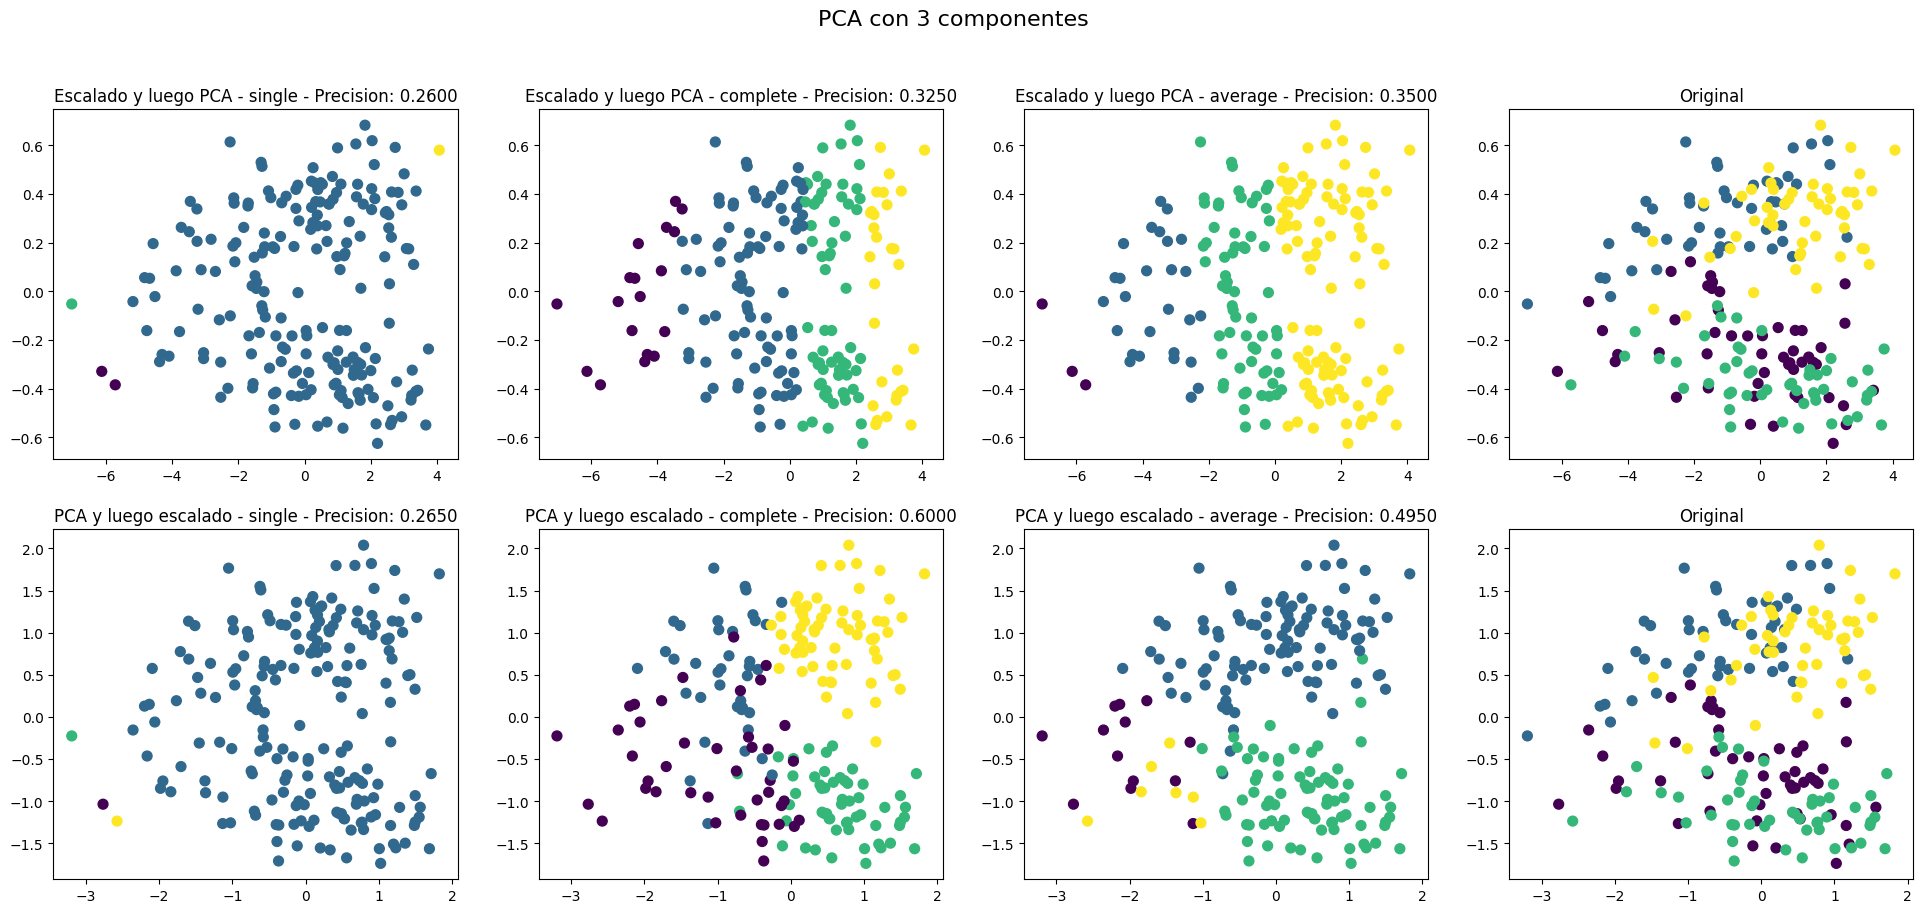

In [ ]:
X = crabs.drop(columns=["sp", "sex"])
y = crabs[["sp", "sex"]]
original = pd.factorize(pd.Series(zip(y["sp"], y["sex"])))[0]

X_log = np.log(X)
X_scaled = scale(X_log, axis=0)

# Probar PCA con 2 y 3 componentes
components_list = [2,3]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X_log).astype(np.double)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled).astype(np.double)

    fig, axes = plt.subplots(2, 4, figsize=(24, 10))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    # Probar linkage jerárquico con distintos métodos
    # Usamos 4 clusters ya que hay dos especies y dos sexos
    for i, method in enumerate(['single', 'complete', 'average']):
        clusters = cut_tree(linkage(X_scaled_pca, method=method), 4)
        precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
        axes[0][i].set_title("Escalado y luego PCA - " + method + " - " + f"Precision: {precision:.4f}")
        axes[0][i].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][3].set_title("Original")
    axes[0][3].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    for i, method in enumerate(['single', 'complete', 'average']):
        clusters = cut_tree(linkage(X_pca_scaled, method=method), 4)
        precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
        axes[1][i].set_title("PCA y luego escalado - " + method + " - " + f"Precision: {precision:.4f}")
        axes[1][i].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][3].set_title("Original")
    axes[1][3].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

Vemos la misma dinamica que con kmeans hacer la PCA primero y luego escalar es mejor. Pero ahora vemos que agregar una tercera componente a la PCA o no ayuda tanto o incluso emperora como cuando se usa el metodo Avarage. Single linkage vemos que tiene un rendimiento muy pobre (casi como un random) debido a algunos muy leves outliers, mostrando su sesibilidad extrema a ellos. En general vemos un rendimiento mas pobre que kmeans.

# Lampone

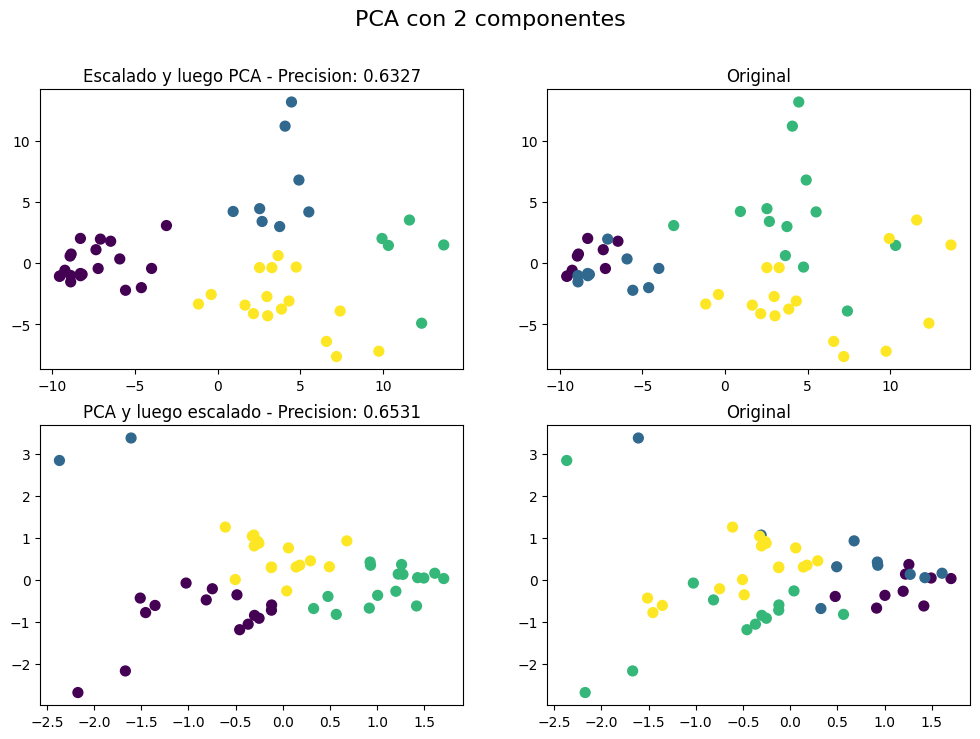

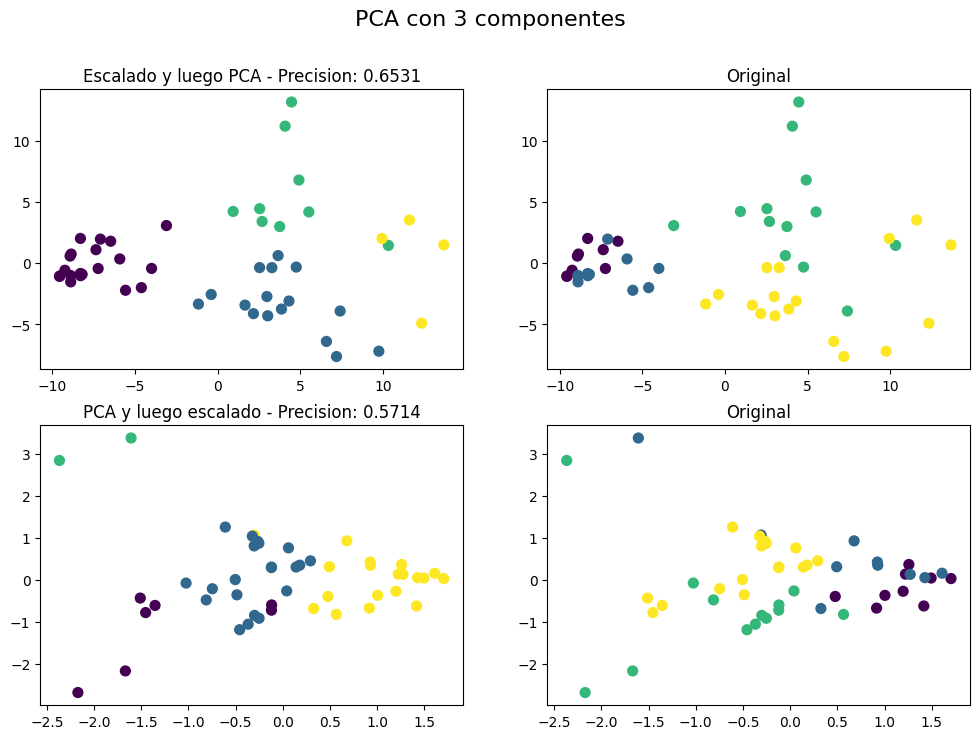

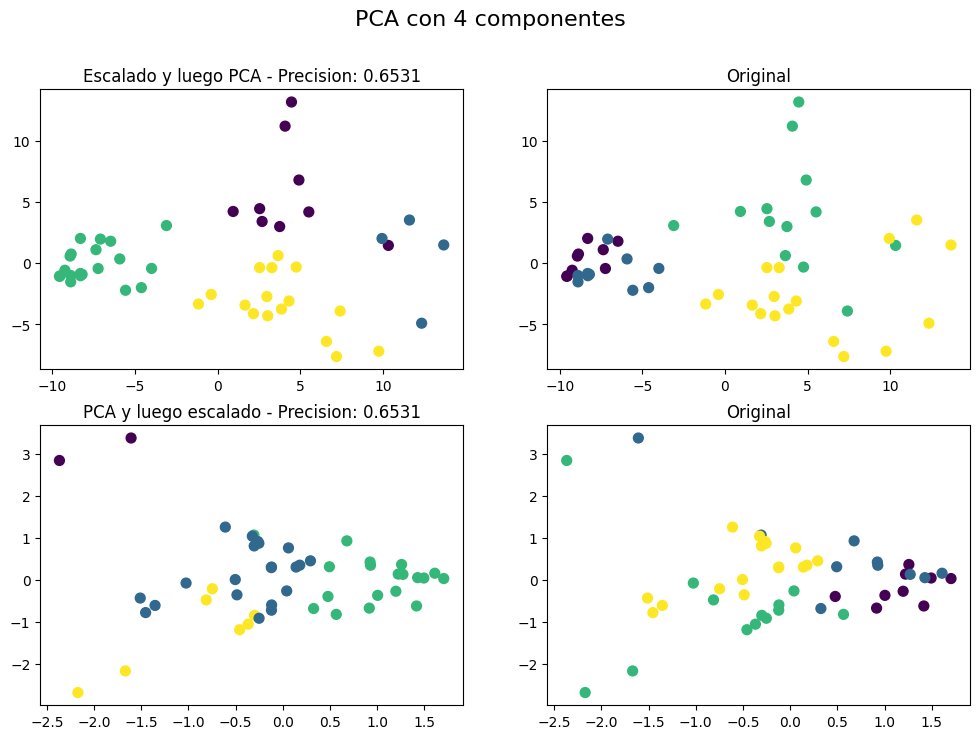

In [ ]:
X = lampone.drop(columns=lampone.columns[[0,142,143]])
y = lampone[lampone.columns[[0,142]]]
original = pd.factorize(pd.Series(zip(lampone.iloc[:, 0], lampone.iloc[:, 142])))[0]

# no aplica logaritmo ya que hay muchos ceros 
# ¿Siempre se tiene que hacer o era para crabs?
#X_log = np.log(X)
X_scaled = scale(X, axis=0)


# Probar PCA con 2, 3 y 4 componentes
components_list = [2,3,4]
for components in components_list:
    # Primero la PCA y luego escalar
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X)
    X_pca_scaled = scale(X_pca, axis=0)

    # Primero escalar y luego PCA 
    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_scaled_pca)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[0][0].set_title("Escalado y luego PCA - " + f"Precision: {precision:.4f}")
    axes[0][0].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][1].set_title("Original")
    axes[0][1].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X_pca_scaled)
    precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
    axes[1][0].set_title("PCA y luego escalado - " + f"Precision: {precision:.4f}")
    axes[1][0].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][1].set_title("Original")
    axes[1][1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

En este caso vemos que hay poca diferencia o es incluso peor primero hacer la PCA y luego escalar, a diferencia del anterior dataset. Esto parece ser debido a la existencia de varios claros outliers que distorsionan las medida de varianza usada por la PCA. Haciendo que el metodo tenga el resultado opuesto. En cambio primero escalar y luego hacer la PCA tiene el resultado opuesto sacandole importancia a los outliers. Podriamos concluir que es importante ver y/o manejar la existencia de outliers antes calcular los clusters.

Tambien vemos que las cantidad de componentes de la PCA no parece cambiear mucho el rendimiento, debe ser porque tiene pocas dimensiones que varian significativamente.  

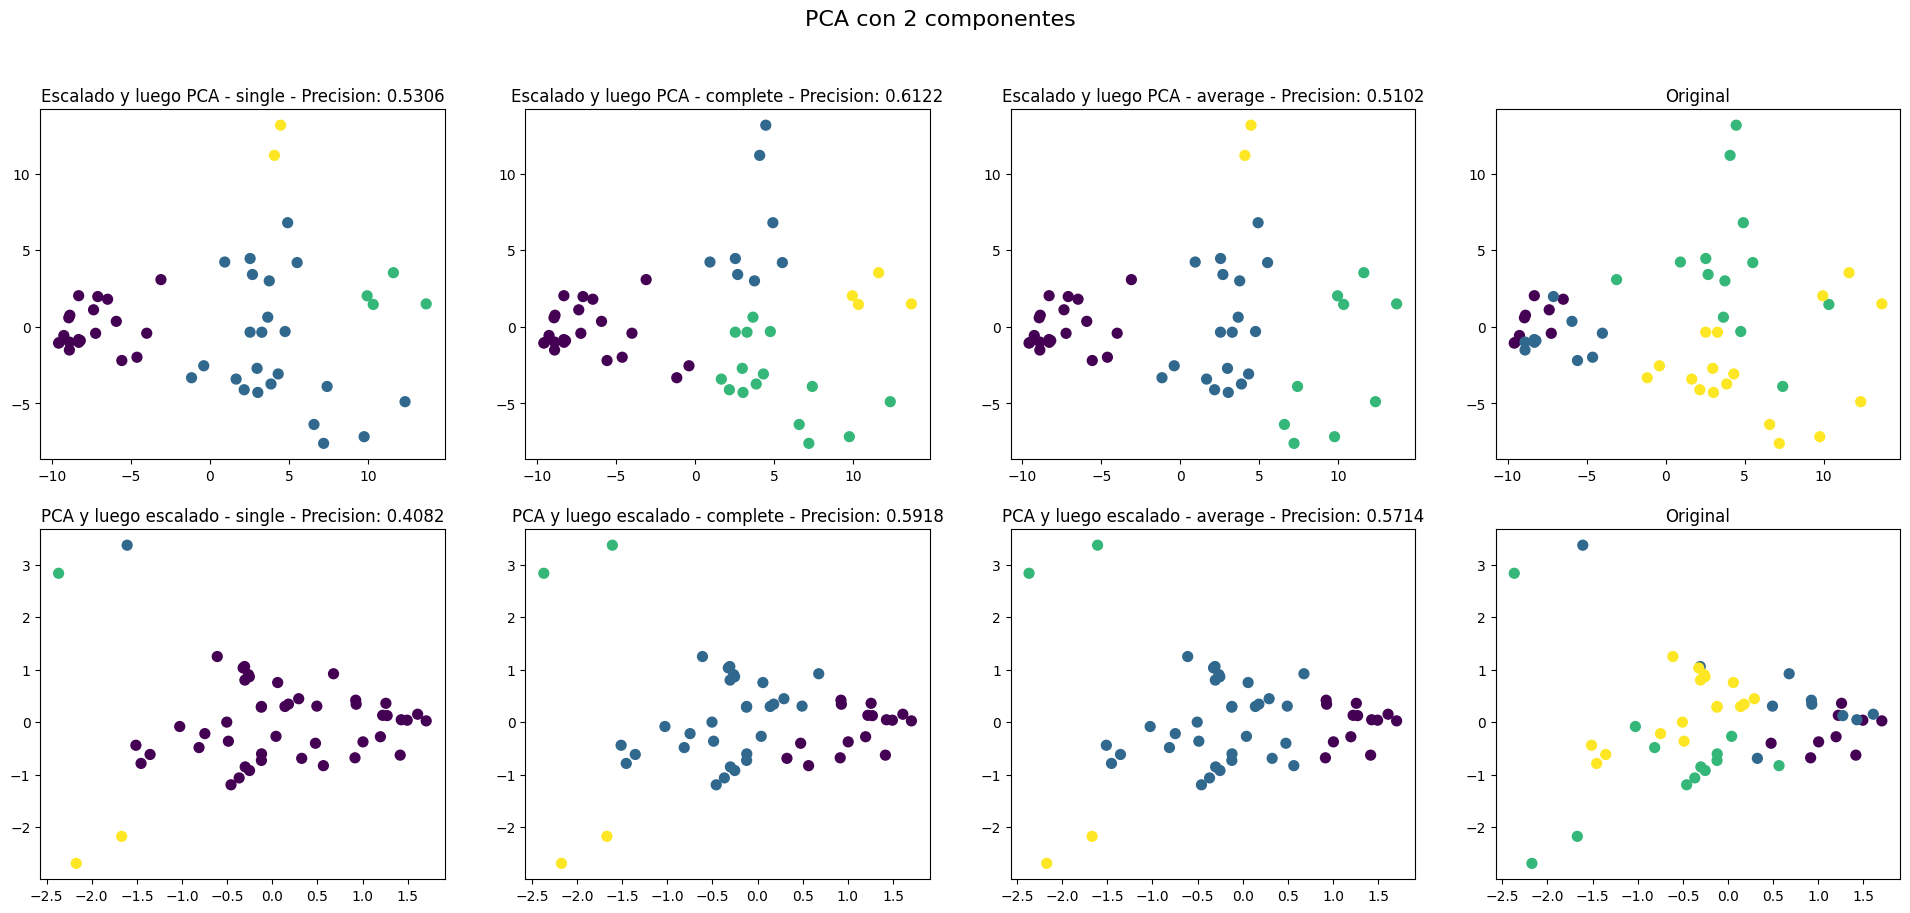

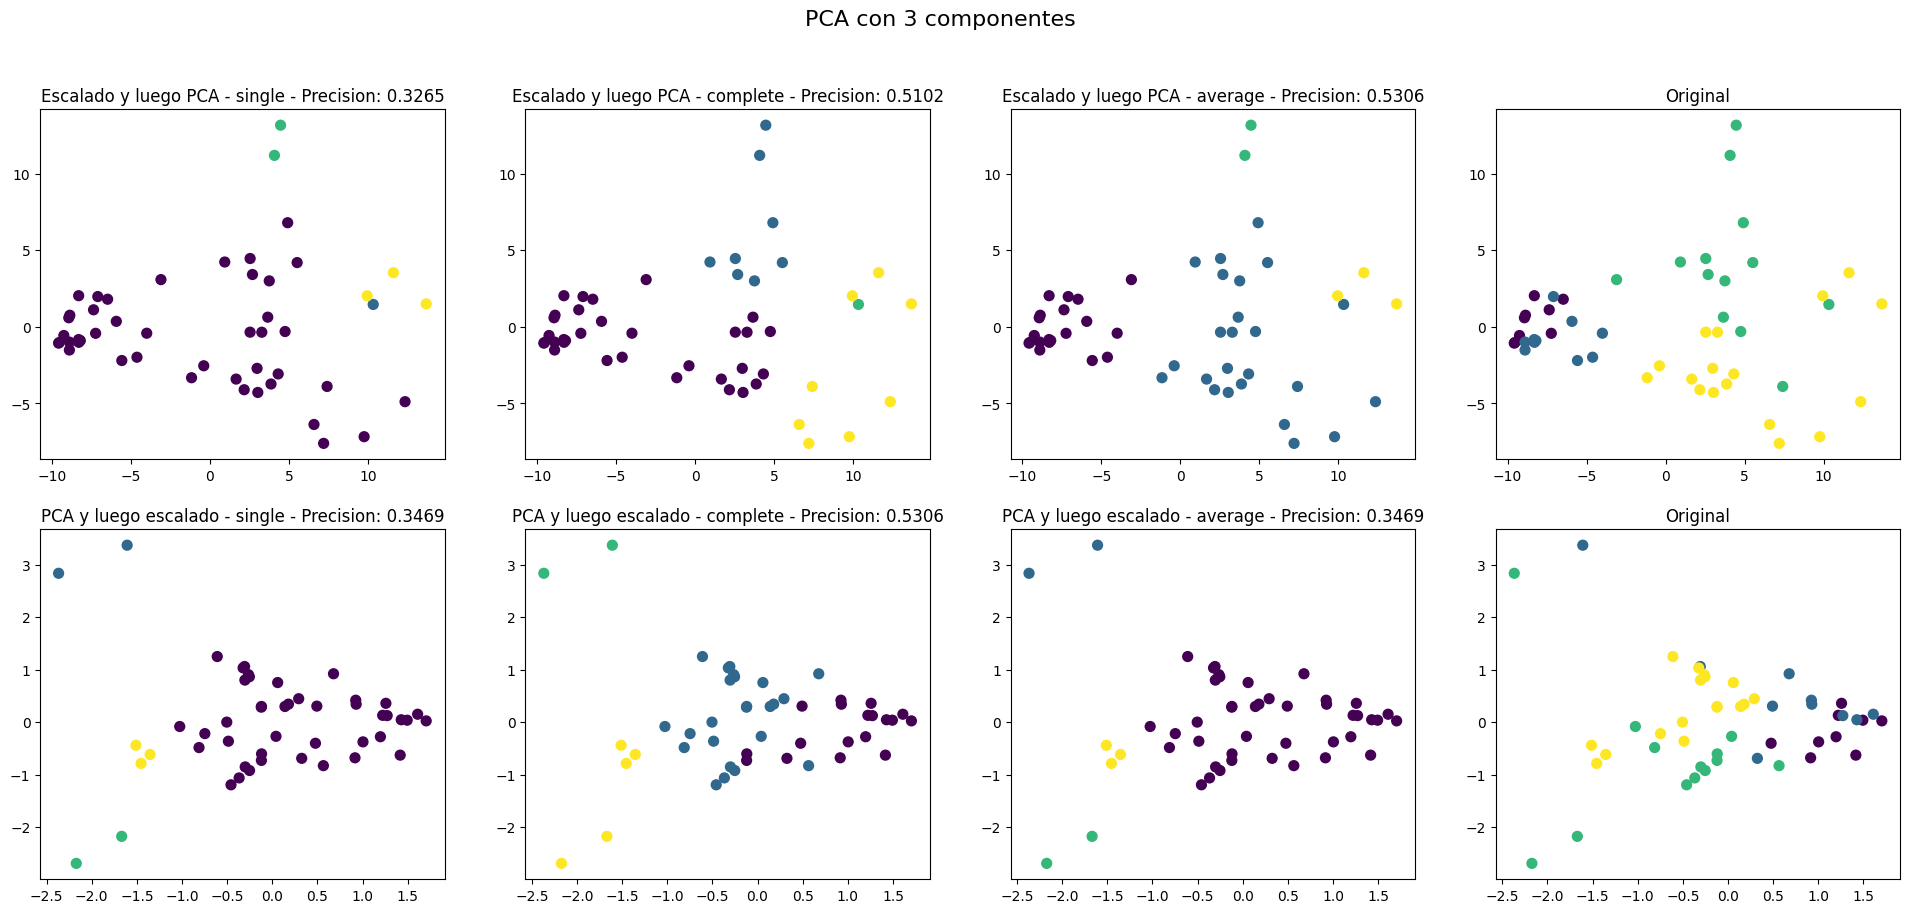

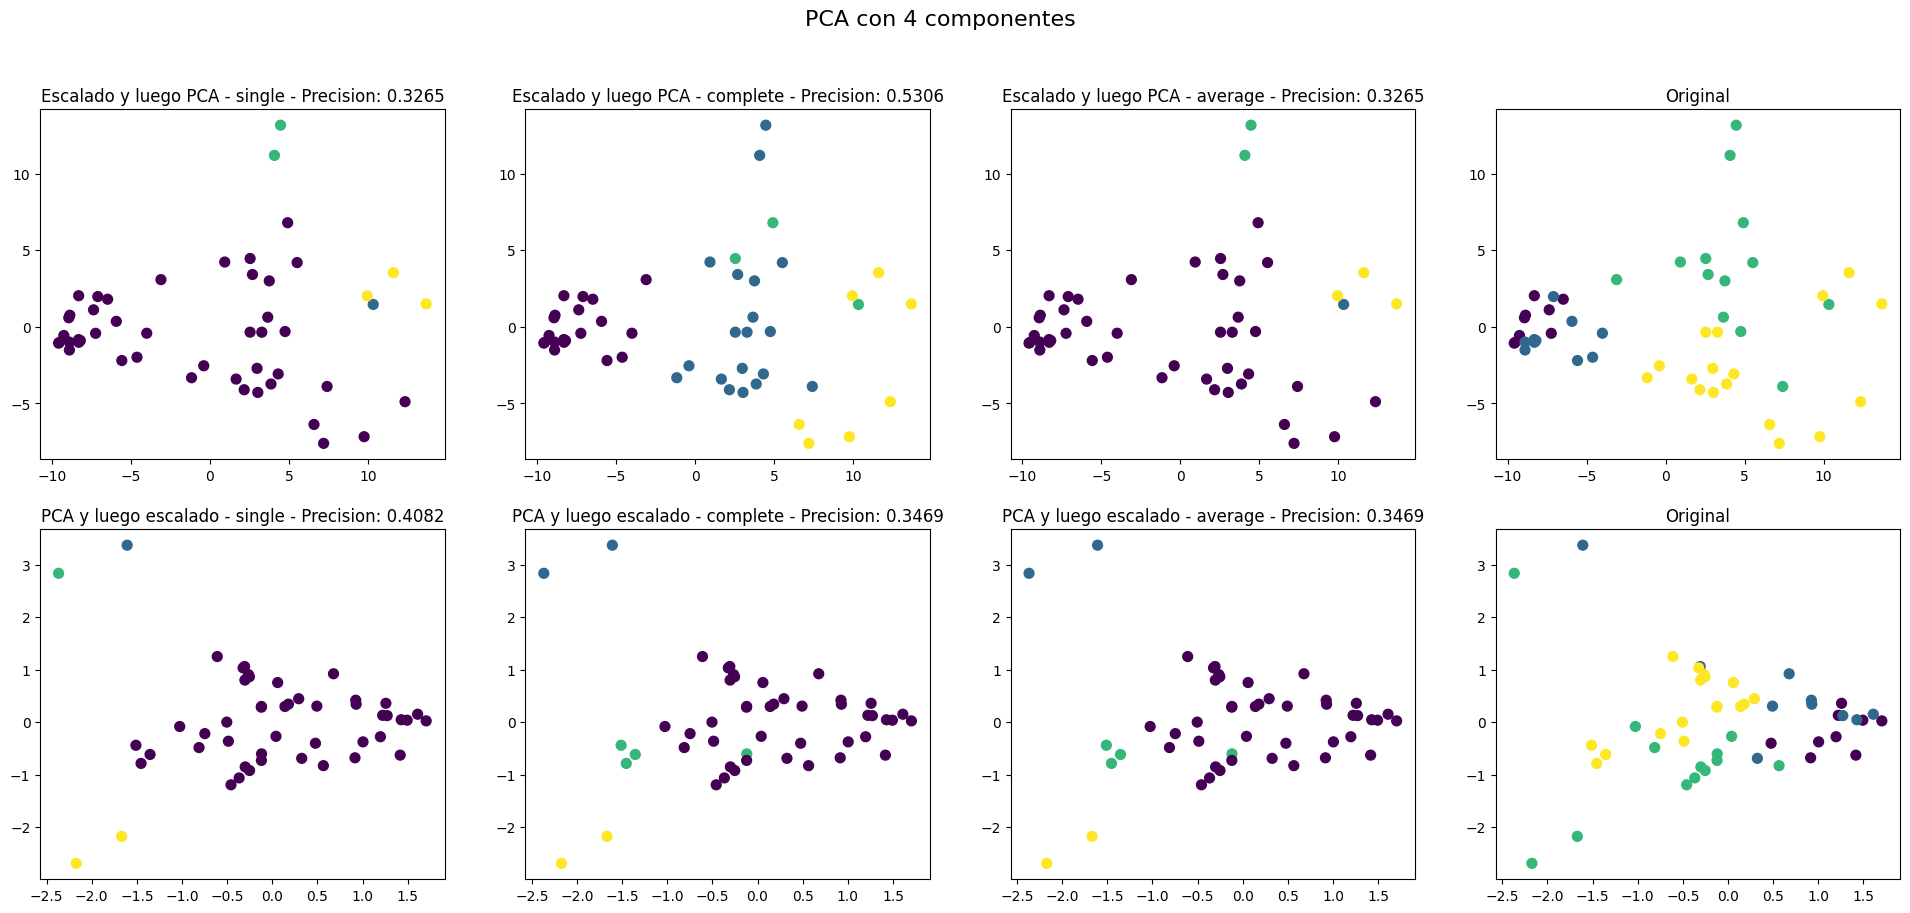

In [90]:
X = lampone.drop(columns=lampone.columns[[0,142,143]])
y = lampone[lampone.columns[[0,142]]]
original = pd.factorize(pd.Series(zip(lampone.iloc[:, 0], lampone.iloc[:, 142])))[0]

#X_log = np.log(X)
X_scaled = scale(X, axis=0)

# Probar PCA con 2 y 3 componentes
components_list = [2,3,4]
for components in components_list:
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(X).astype(np.double)
    X_pca_scaled = scale(X_pca, axis=0)

    pca = PCA(n_components=components)
    X_scaled_pca = pca.fit_transform(X_scaled).astype(np.double)

    fig, axes = plt.subplots(2, 4, figsize=(24, 10))
    fig.suptitle(f"PCA con {components} componentes", fontsize=16)
    for i, method in enumerate(['single', 'complete', 'average']):
        clusters = cut_tree(linkage(X_scaled_pca, method=method), 4)
        precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
        axes[0][i].set_title("Escalado y luego PCA - " + method + " - " + f"Precision: {precision:.4f}")
        axes[0][i].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=clusters, cmap="viridis", s=50)
    axes[0][3].set_title("Original")
    axes[0][3].scatter(X_scaled_pca[:,0], X_scaled_pca[:,1], c=original, cmap="viridis", s=50)

    for i, method in enumerate(['single', 'complete', 'average']):
        clusters = cut_tree(linkage(X_pca_scaled, method=method), 4)
        precision = precision_conf_matrix(comparar_tabla_optim(clusters, original))
        axes[1][i].set_title("PCA y luego escalado - " + method + " - " + f"Precision: {precision:.4f}")
        axes[1][i].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=clusters, cmap="viridis", s=50)
    axes[1][3].set_title("Original")
    axes[1][3].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=original, cmap="viridis", s=50)

Vemos que en general parece que el clustering divisivo, por lo menos con estos metodos son mas afectados por la baja densidad de datos en el espacio. Y tambien parecen ser afectados por los outliers mas que kmeans.

# Ejercicio 2
## GAP

In [ ]:
def gap_statistic(X, max_k, ran_samples=3, plot=False):
    shape = X.shape
    max_PCAcomponents = min(shape)
    results = [] #pd.DataFrame({'clusters':[], 'gap':[], 'std':[], 's':[]})
    for k in range(1, max_k + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=0)
        km.fit(X)
        
        # inertia es la dispersión
        dispersion = km.inertia_

        disps_samples = np.zeros(ran_samples)

        for i in range(ran_samples):
            # Generar datos aleatorios uniformes en el mismo rango que X
            # Usamos PCA 
            pca = PCA(n_components=max_PCAcomponents)
            X_pca = pca.fit_transform(X)
            random_data_pca = np.random.uniform(low=np.min(X_pca, axis=0), high=np.max(X_pca, axis=0), size=(shape[0], max_PCAcomponents))
            # Volvemos al espacio original
            #random_data = pca.inverse_transform(random_data_pca)
            km.fit(random_data_pca)
            disps_samples[i] = km.inertia_

        gap = np.mean(np.log(disps_samples)) - np.log(dispersion)
        std = np.std(np.log(disps_samples)) 
        #l = np.mean(np.log(disps_samples))
        #std = np.sqrt(np.mean((np.log(disps_samples) - l)**2))
        s = std * np.sqrt(1 + (1 / ran_samples))
        results.append({'clusters':k, 'gap':gap, 'std':std, 's':s})
    results_df = pd.DataFrame(results)

    opt_clusters = None
    opt_clusters_idx = None
    # Buscar el menor k tal que: Gap(k-1) >= Gap(k) - s(k)
    for i in range(1, len(results_df)):
        if results_df.loc[i-1, 'gap'] >= results_df.loc[i, 'gap'] - results_df.loc[i, 's']:
            opt_clusters = results_df.loc[i-1, 'clusters']
            opt_clusters_idx = i-1
            break

    if plot:
        plt.figure(figsize=(8,6))
        plt.errorbar(results_df['clusters'], results_df['gap'], yerr=results_df['std'], fmt='o-', capsize=5, label='data with error')
        plt.scatter(opt_clusters, results_df.loc[opt_clusters_idx,'gap'], color='red', s=100, zorder=5, label='highlighted point')
        plt.show()

    return opt_clusters, results_df

# Estabilidad

In [109]:
def compute_similarity_matrix(v):
    n = v.shape[0]
    is_valid = v > 0
    valid_mask = np.logical_and.outer(is_valid, is_valid)
    eq_mask = np.equal.outer(v, v)
    m = np.zeros((n,n), dtype=int)
    m[valid_mask & eq_mask] = 1
    m[valid_mask & ~eq_mask] = -1
    return m

# Función para graficar la estabilidad acumulada
# linea de puntos, se va agregando cada loop
def plot_stability(similarities, k):
    cmap = plt.cm.tab10
    color1 = cmap(k / 10)
    similarities = np.sort(similarities)
    cumulative = np.arange(1, len(similarities) + 1) / len(similarities)
    plt.plot(similarities, cumulative, '.', markersize=4, color=color1, label=f'k={k}')

#from sklearn.metrics import adjusted_rand_score
def estabilidad(X, max_k, ran_samples=5, plot=False):
    shape = X.shape
    results = [] 
    n = shape[0]
    plt.figure(figsize=(8, 6))
    plt.xlabel('similarity')
    plt.ylabel('cumulative')
    plt.grid(False)
    for k in range(2, max_k + 1):
        scores = []
        labels_lists = []

        # Generar ran_samples clusterings con KMeans en muestras aleatorias del 90% de los datos
        for i in range(ran_samples):
            ind = np.random.choice(n, int(0.90 * n), replace=False)
            cc = KMeans(n_clusters=k, n_init=10, random_state=0).fit(X[ind]).labels_
            v = np.zeros(n, dtype=int)
            v[ind] = cc + 5
            labels_lists.append(v)

        # Calcular las matrices de similitud y los scores de todos los pares de posibles clusters calculados
        for i in range(ran_samples):
            for j in range(i+1, ran_samples):
                v1 = labels_lists[i]
                v2 = labels_lists[j]
                m1 = compute_similarity_matrix(v1)
                m2 = compute_similarity_matrix(v2)

                # Calcular el score de estabilidad
                validos = np.sum((v1 * v2) > 0)
                if validos > 1:
                    score = np.sum((m1 * m2)[np.triu_indices(n, k=1)] > 0) / (validos * (validos - 1) / 2)
                else:
                    score = 0  # Evita división por cero
                #score = adjusted_rand_score(v1,v2)
                scores.append(score)

        
        plot_stability(scores, k)
        results.append({'clusters':k, 'stability':np.mean(scores), 'std':np.std(scores)})
    results_df = pd.DataFrame(results)

    if plot:
        plt.legend()
        plt.show()
        #plt.figure(figsize=(8,6))
        #plt.errorbar(results_df['clusters'], results_df['stability'], yerr=results_df['std'], fmt='o-', capsize=5, label='data with error')

    best = results_df.loc[results_df['stability'].idxmax()]['clusters']
    return best,results_df

In [94]:
def genera_cuatro_gausianas(n = 100, gap = 2):
    gausianas = np.zeros((4*n, 3))

    centers = np.array([
        [-gap, -gap],
        [-gap, gap],
        [gap, -gap],
        [gap, gap]
    ])

    for i, center in enumerate(centers):
        x = np.random.normal(center[0], size=n)
        y = np.random.normal(center[1], size=n)
        c = np.repeat(i, n)
        gausianas[(i*n):((i+1)*n), :] = np.vstack((x, y, c)).T

    return gausianas

# Ejercicio 3: Cuatro gausianas

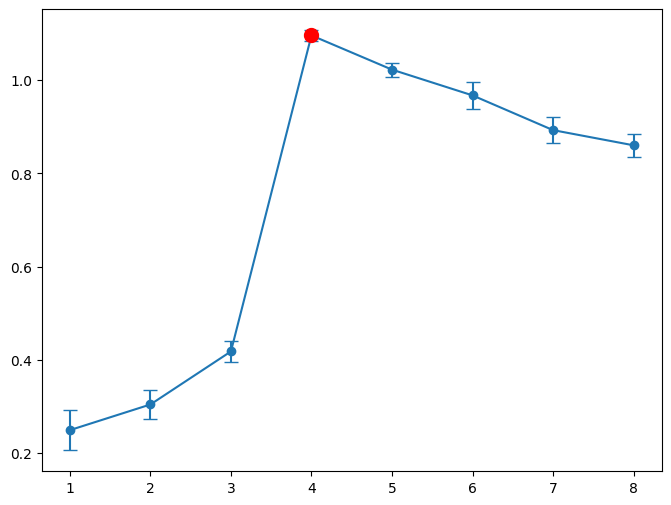

Optimal k from Gap Statistic: 4


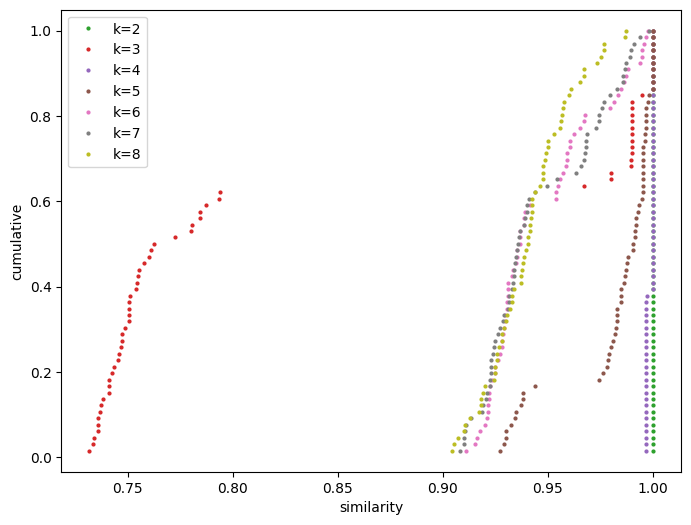

Optimal k from Stability: 2.0


In [107]:
# cuatro_gausianas con poco ruido
gaus = genera_cuatro_gausianas(gap=3) 
#plt.figure(figsize=(8,6))
#plt.scatter(gaus[:, 0], gaus[:, 1], c=gaus[:, 2], cmap='tab10', s=30)
k, _ = gap_statistic(gaus[:, :2], max_k=8, ran_samples=5, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(gaus[:, :2], max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)



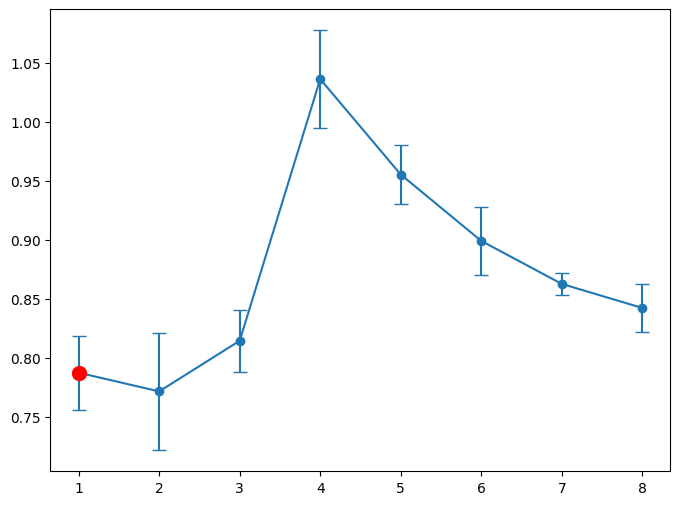

Optimal k from Gap Statistic: 1


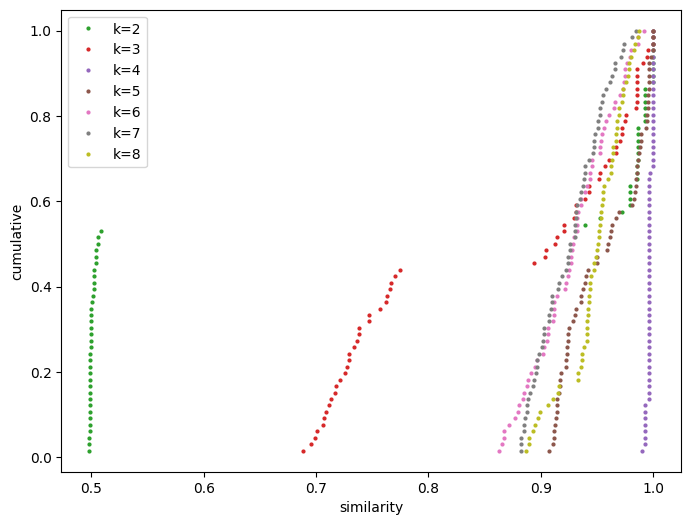

Optimal k from Stability: 4.0


In [ ]:
# cuatro_gausianas con mas ruido
gaus = genera_cuatro_gausianas(gap=2) 
k, _ = gap_statistic(gaus[:, :2], max_k=8, ran_samples=5, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(gaus[:, :2], max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

Vemos que cuando hay poco ruido el metodo de gap funciona rapido y bien, pero cuando se agrega ruido rapidamente falla aunque mirando el grafico igualmente podemos distinguir un numero posible de clusters. En cambio el metodo de la estabilidad maneja muy bien el ruido pero falla cuando los datos tienen poco ruido o son muy tienen numeros de clusters que dan soluciones muy estables. Como en el caso que la distancia entre las gausianas era mayor que elige k=2. Creo que se podria mejorar combinando los distintos metodos para perturbar los datos.

# Iris

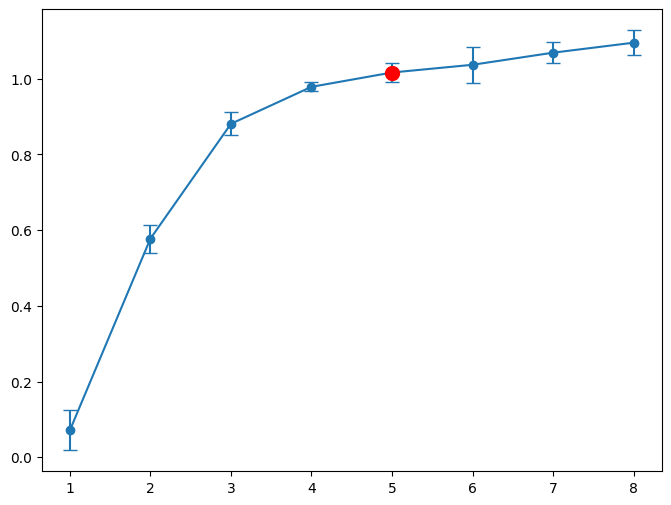

Optimal k from Gap Statistic: 5


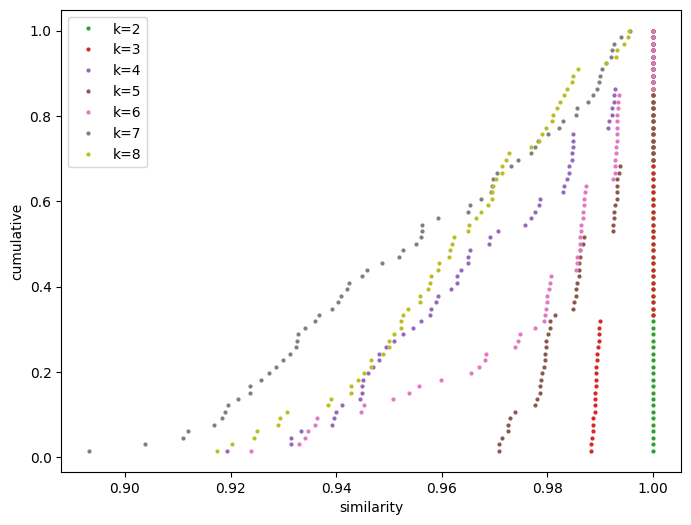

Optimal k from Stability: 2.0


In [110]:
# Cargo dataset iris
iris = load_iris(as_frame=True)
X = np.array(iris.data)
y = iris.target

k, _ = gap_statistic(X, max_k=8, ran_samples=6, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(X, max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

Para el caso Iris vemos que ninguno de los dos metodos funciona muy bien, para el caso de GapStat vemos que la curva de gap siempre crece lentamente pese a que despues de k=3 crece notablemente mas lento, complica la seleccion automatica de k. Pero a ojo igual se ve mejor. 

El metodo de estabilidad vemos que no funciona ya que la distribucion de los datos es asimetrica, con los dos clusters opuestos al otro pegados. Haciendo que k=2 sea mas estable que la solucion real k=3.

# Lampone

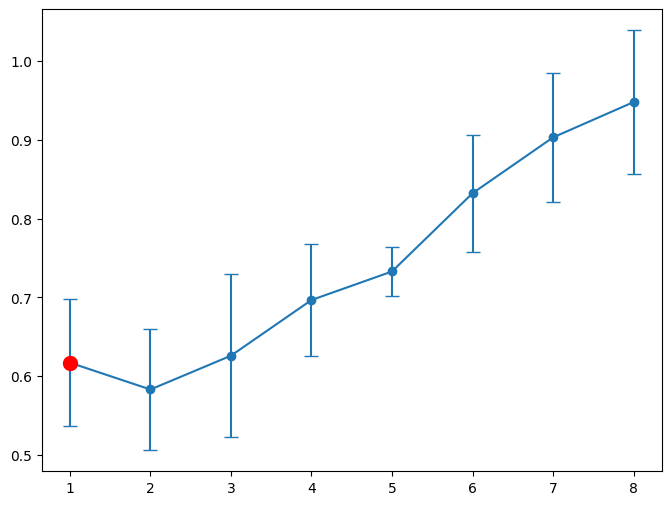

Optimal k from Gap Statistic: 1


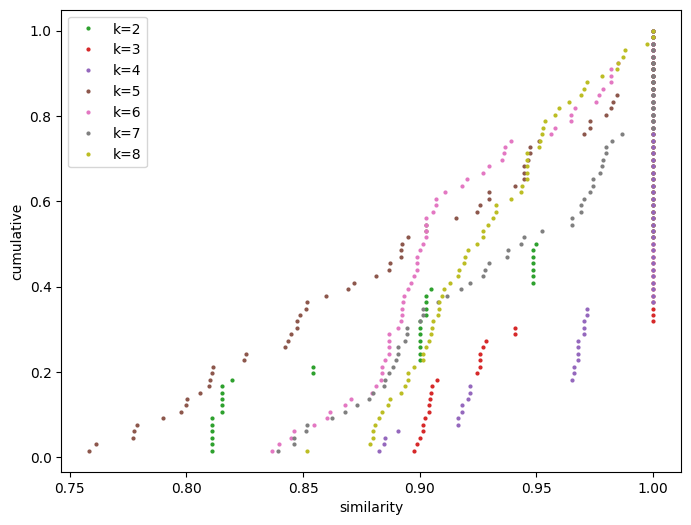

Optimal k from Stability: 4.0


In [120]:
X = np.array(lampone.drop(columns=lampone.columns[[0,142,143]]))
y = lampone[lampone.columns[[0,142]]]

k, _ = gap_statistic(X, max_k=8, ran_samples=6, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(X, max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

Vemos que gapStat da bastante mal, ni mirar el grafico ayuda para encontrar un el numero de clusters. En cambio el metodo de la estabilidad funciono mucho mejor, dando un resultado correcto aunque mirando la grafica vemos que k=3 esta bastante similar. De cualquier manera se ve que en datasets donde los datos estan mas sucios estabilidad funciona mejor.

# Ejercicio 4

Elegi el dataset Student Habits vs Academic Performance porque me resultaba interesante. Quiero encontrar grupos de estudiantes y ver que tienen en comun y que los diferencia.

In [ ]:
df = pd.read_csv('student_habits_performance.csv')
df = pd.DataFrame(df)
display(df.head())
display(df.info())

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

None

In [135]:
# Manejo de valores faltantes y codificación de variables categóricas
df['parental_education_level'] = df['parental_education_level'].fillna(df['parental_education_level'].mode()[0])
df2 = df.drop('student_id', axis=1)
diet_quality = {'Poor': 0, 'Fair': 1, 'Good': 2}
parental_education_level = {'High School' : 0, 'Bachelor' : 1, 'Master' : 2}
internet_quality  = {'Poor' : 0, 'Average' : 1, 'Good' : 2}
part_time_job = {'No' : -1, 'Yes' : 1}
extracurricular_participation = {'No' : -1, 'Yes' : 1}
#df2['dietq_e'] = df2['diet_quality'].map(diet_quality)
#df2['ped_e'] = df2['parental_education_level'].map(parental_education_level)
#df2['iq_e'] = df2['internet_quality'].map(internet_quality)
#df2['pt_e'] = df2['part_time_job'].map(part_time_job)
df2 = df2.drop(['gender',
          'part_time_job',
          'diet_quality',
          'parental_education_level',
          'internet_quality',
          'extracurricular_participation'], axis=1)


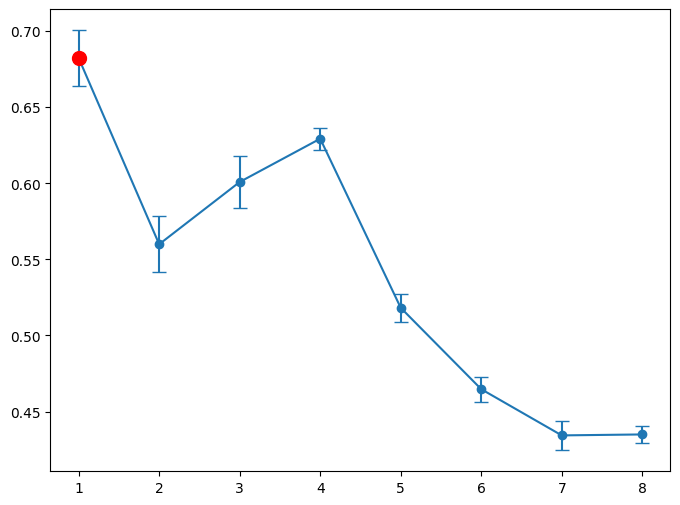

Optimal k from Gap Statistic: 1


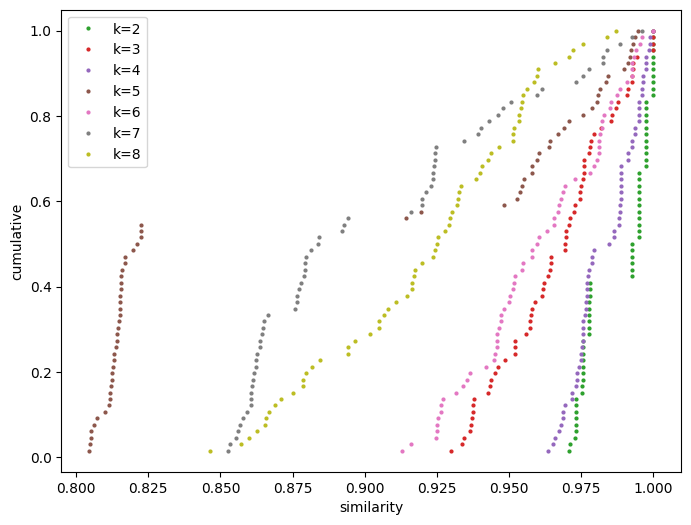

Optimal k from Stability: 2.0


In [141]:
X = np.array(df2.values)
k, _ = gap_statistic(X, max_k=8, ran_samples=5, plot=True)
print("Optimal k from Gap Statistic:", k)
k, _ = estabilidad(X, max_k=8, ran_samples=12, plot=True)
print("Optimal k from Stability:", k)

Viendo ambos graficos seleccionamos 4 clusters ya que quiero buscar agrupamientos de los datos, ademas 4 tiene un gap importante y es el mas estable, k=2 tiene varias discontinuidades en la similitudes.  

In [130]:
from scipy.stats import kruskal
import seaborn as sns  # visualización estilo matplotlib, trae datasets
from sklearn.preprocessing import StandardScaler

# Implementación del filtro de Kruskal-Wallis para ranking de características
def filter_kruskal(
        X: np.ndarray, y: np.ndarray,
        verbosity: int = 0, **kwargs):
    _, max_feat = X.shape  # total de features

    stats = np.zeros(max_feat)
    pvalues = np.zeros(max_feat)

    # Para cada variable, la separo en grupos usando el target y comparo los 
    # grupos usando kruskal-wallis. Mientras mas mayor sea el stat mayor diferencia
    # hay entre los grupos y por lo que la variable separa mejor las clases
    for num_feat in range(max_feat):
        x = X[:, num_feat]
        groups = [x[y == val] for val in np.unique(y)]
        H, p = kruskal(*groups)
        stats[num_feat] = H
        pvalues[num_feat] = p

    if verbosity > 2:
        print(f'\n------------\nStats of features: {stats}\n')
        print(f'\n------------\nPvalues of features: {pvalues}\n')
    order = np.argsort(-stats)
    if verbosity > 1:
        print(f'\n------------\nFinal ranking of features: {order}\n')
        
    return order

Index(['exam_score', 'study_hours_per_day', 'attendance_percentage',
       'mental_health_rating', 'social_media_hours', 'exercise_frequency',
       'netflix_hours', 'sleep_hours', 'age'],
      dtype='object')


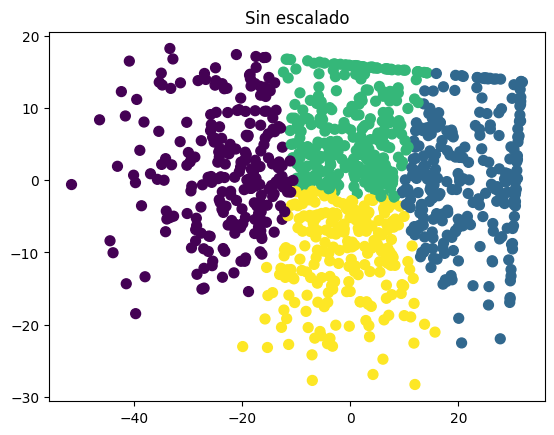

         exam_score  study_hours_per_day  attendance_percentage  \
cluster                                                           
0         46.774138             1.872845              83.980603   
1         90.681008             5.055426              85.878295   
2         69.509859             3.493662              90.949296   
3         69.085841             3.624336              73.725664   

         mental_health_rating  social_media_hours  exercise_frequency  \
cluster                                                                 
0                    4.366379            2.746983            2.637931   
1                    6.635659            2.208527            3.500000   
2                    5.211268            2.653873            3.095070   
3                    5.455752            2.410177            2.867257   

         netflix_hours  sleep_hours        age  
cluster                                         
0             2.040948     6.371121  20.616379  
1          

In [143]:
X = np.array(df2.values)
pca = PCA(n_components=2)
X_scaled = scale(X, axis=0)
X_pca = pca.fit_transform(X)
clusters = KMeans(n_clusters=4, n_init=10, random_state=0).fit_predict(X)

ranked_names = df2.columns[filter_kruskal(X, clusters)]
print(ranked_names)

#scaler = StandardScaler()
#scaled = scaler.fit_transform(df2)
#df3 = pd.DataFrame(scaled, columns=df2.columns)

plt.title("Sin escalado")
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis", s=50)
plt.show()

df3 = df2.copy()
df3['cluster'] = clusters
print(df3.groupby('cluster').mean()[ranked_names])
#sns.pairplot(df3, hue="cluster", diag_kind="kde")

Vemos que los clusters quedaron bastante bien separados principalmente por la nota, horas de estudio, asistencia, salud mental. A su vez notamos que las a mas horas de estudio mejor nota. Vemos que hay dos grupos de estudiantes con la misma nota y horas de estudio pero son separados por la asistencia. 
Vemos que la salud mental tambien esta relacionada con una nota mas alta.